In [ ]:
from linkedin_api import Linkedin
from dotenv import load_dotenv
import os
load_dotenv()

In [ ]:
def get_model(model: str = 'deepseek-r1:7b', provider: str = 'local'):
    if (provider == 'local'):
        from langchain_ollama import ChatOllama
        llm = ChatOllama(model=model, temperature=0.8)
        return llm
    elif (provider=='llama'):
        from langchain_ollama import ChatOllama
        llm = ChatOllama(model='llama3.1', temperature=0.8)
        return llm
    elif (provider == 'aws'):
        from langchain_aws import ChatBedrockConverse
        import boto3
        access_key = os.getenv('ACCESS_KEY')
        secret_key = os.getenv('SECRET_KEY')
        bedrock_client = boto3.client('bedrock-runtime',
                                      region_name='us-east-1',
                                      aws_access_key_id=access_key,
                                      aws_secret_access_key=secret_key)
        llm = ChatBedrockConverse(client=bedrock_client,
                                  model=model,
                                  temperature=0.8)
        return llm


def get_embeddings(model:str='deepseek-r1:7b', provider:str='local'):
    if(provider == 'local'):
        from langchain_ollama import OllamaEmbeddings
        embeddings=OllamaEmbeddings(model=model)
        return embeddings
    elif(provider == 'aws'):
        from langchain_aws import BedrockEmbeddings
        import boto3
        access_key=os.getenv('ACCESS_KEY')
        secret_key=os.getenv('SECRET_KEY')
        bedrock_client=boto3.client('bedrock-runtime', region_name='us-east-1', aws_access_key_id=access_key, aws_secret_access_key=secret_key)
        embeddings=BedrockEmbeddings(client=bedrock_client, model_id=model)
        return embeddings

In [ ]:
user_name=os.getenv('LINKEDIN_NAME')
user_pass=os.getenv('LINKEDIN_PASSWORD')

api=Linkedin(user_name,user_pass)
print(dir(api))

In [ ]:
feed_result=api.get_profile_posts(public_id='nir-diamant-ai')

In [ ]:
print(feed_result[0]['actor']['name']['text'])

In [ ]:
import re

links = []
posts=[]
public_ids=['nir-diamant-ai','areganti']
for id in public_ids:
    feed_result=api.get_profile_posts(public_id=id, post_count=5)
    author=feed_result[0]['actor']['name']['text']
    for idx, result in enumerate(feed_result):
        text = f"Author:{author}\n\n{result['commentary']['text']['text']}"
        
        posts.append({"idx":idx,"post":text})
        # print(text)
        url_pattern = r"https?://\S+"
        urls = re.findall(url_pattern, text)
        for url in urls:
            links.append({"idx": idx, "url": url})
    # print("-" * 80)

# print(links)

In [143]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import List, Tuple, Annotated, TypedDict
import operator
from langchain_core.prompts import PromptTemplate


class GraphState(TypedDict):
    intermediate_steps: Annotated[List[Tuple], operator.add]
    summaries:List[str]
    feeds:List[str]
    top_feeds:str

model=get_model()
def summarize_text(state:GraphState):
    prompt=PromptTemplate(
        template=
        """
        System: You will be given a linkedin post and you will try to summarize it capturing as much information as possible. 
        Include the name of the author in the summary as well
        User: Linkedin Post \n:{text}
        """,
        input_variables=['text']
    )
    chain=prompt|model

    summaries=[]
    steps=[]
    for feed in state['feeds']:
        response=chain.invoke({"text":feed})
        summaries.append(response.content)
        steps.append((feed, response.content))


    return {"summaries":summaries, "intermediate_steps":steps}


def get_feeds(state: GraphState):
    # print("inside top feeds")
    summaries_arr = state['summaries']
    summaries = "\n\n".join(summaries_arr)
    # print("summaries_required")
    # print(summaries)
    prompt = PromptTemplate(template="""
        System: 
            You will be provided with multiple summaries of LinkedIn posts. Your task is to select the top 5 LinkedIn posts based on the following criteria:
            Prioritize posts that highlight the latest AI releases.
            Give more importance to posts showcasing AI project ideas and demos.
            Ignore posts that are promoting courses or course enrollments.
        Instructions:
            -Include the author's name in each selected summary.
            -Format your output in a structured way for readability.
            -Additionally, use the selected summaries to create a podcast script summarizing the key insights from these top 5 posts.
        User: Linkedin Post \n:{summaries}. Top 5 Linkedin Posts:\n\n
        """,
        input_variables=['summaries'])
    chain = prompt | model

    response = chain.invoke({"summaries": summaries})
    # print(response.content)
    return {
        "top_feeds": response.content,
        "intermediate_steps": [(summaries, response.content)]
    }


In [144]:
memory=MemorySaver()
workflow=StateGraph(GraphState)

workflow.add_node("Summarizer",summarize_text)
workflow.add_node("Top_feeds",get_feeds)

workflow.add_edge("Summarizer","Top_feeds")
workflow.add_edge("Top_feeds",END)
workflow.set_entry_point("Summarizer")

graph=workflow.compile(checkpointer=memory)




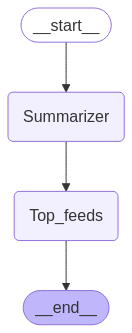

In [145]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    print("fail")
    pass

In [146]:
respone=graph.invoke({"feeds":posts},config={"configurable": {"thread_id": "1"}})
    

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


In [147]:
print(respone['top_feeds'])

<think>
Okay, so I need to summarize this LinkedIn post by Aishwarya Naresh Reganti about the challenges in online tech interviews being overtaken by AI. The user has provided some key points from the post.

First, I should identify the main issues addressed: outdated processes in online tech interviews due to AI advancements, how many interview questions and codes can be answered by AI models, and the potential implications for human interviewers. Then, include specific examples like the interview app mentioned and the actual FAQ table provided.

I need to make sure the summary is concise but covers all these points without being too lengthy.
</think>

Aishwarya Naresh Reganti critiques the outdated nature of online tech interviews in the AI era, noting that many common questions and codes can now be efficiently answered by AI models. They highlight examples like an interview app designed to assist candidates with such inquiries, adding complexity as it blurs the line between intervie